# Projet UV IMDA   ------ GU Shiyun, WU Yingqi

- DataBase initial ： https://www.kaggle.com/datasets/moltean/fruits



### Puisque chaque classe du jeu de données d’origine ne contenait qu’environ 500 images, nous avons fusionné deux classes correspondant au même fruit.
### Au final, nous avons sélectionné 11 catégories de fruits, avec environ 1 100 images par catégorie.
### Le jeu de données final organisé est disponible dans le lien ci-dessous.**

- Database prétraité : https://drive.google.com/drive/folders/1J037ySeZ0z3Ljbr_USWy1OaDhRrRUrtB?usp=sharing




## Génération d’images à partir d’un label

### Dans ce projet, nous utilisons une variante avancée du Generative Adversarial Network (GAN), inspirée à la fois de DCGAN et d’ACGAN.
Le générateur adopte une architecture convolutionnelle profonde (ConvTranspose2d), typique de DCGAN, ce qui permet de produire des images en haute résolution à partir d’un vecteur de bruit z.

Afin de contrôler la classe de l’image générée (par exemple : pomme, banane, fraise…), le modèle intègre un mécanisme conditionnel :
le bruit z est concaténé avec une représentation one-hot du label, ce qui permet au générateur de produire des images correspondant à une catégorie donnée.

Le discriminateur, quant à lui, suit la structure d’un ACGAN (Auxiliary Classifier GAN).
Il ne se contente pas de distinguer le vrai du faux ; il apprend également à classifier l’image dans l’une des classes de fruits.
Pour cela, il possède deux têtes :

une tête adversariale (real/fake)

une tête auxiliaire (classification du label)

Cette double supervision stabilise l’entraînement, améliore la qualité des images synthétiques et force le générateur à respecter davantage les caractéristiques visuelles propres à chaque fruit.

En résumé, le modèle combine :

DCGAN → architecture convolutionnelle profonde pour la génération d’images,

GAN conditionnel → contrôle explicite de la classe générée,

ACGAN → ajout d’une tête de classification dans le discriminateur, permettant un apprentissage plus riche et plus stable.

###  On utilise cette fois d'abord un GAN convolutif conditionnel (cDCGAN) capable de générer des images RGB de fruits en 128×128 à partir d’un label donné.
Contrairement à un GAN classique, la version conditionnelle intègre l’information de classe à la fois dans le Générateur—où le bruit est concaténé à un embedding du label—et dans le Discriminateur, où le label est converti en un canal supplémentaire de l’image.
Cela permet au modèle de produire des images correspondant précisément à la catégorie choisie (ex : Apple, Banana, Orange).

Le pipeline comprend le prétraitement des données, la construction du modèle, l’entraînement adversarial, la génération d’échantillons et la sauvegarde des poids.
Un script de démonstration séparé permet ensuite de charger le générateur entraîné et de créer de nouvelles images à partir d’un simple label, sans réentraînement.

# Données et hyperparamètres

Dans cette partie, on prépare le chemin d’accès au jeu de données de fruits (dossiers Training / Valid / Test), on définit les transformations d’images (redimensionnement en 128×128, normalisation, éventuelle augmentation de données) et on fixe les principaux hyperparamètres du DCGAN (taille du bruit nz, batch_size, num_epochs, lr, etc.).

In [1]:
# Hyperparamètres & chemins
import os
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim

# Dossier racine de ton jeu de données de fruits
# (il contient trois sous-dossiers : Training / Valid / Test)
DATA_ROOT = r"D:/IMDA CL3/Projet Fruit/data"
TRAIN_DIR = os.path.join(DATA_ROOT, "Training")
VALID_DIR = os.path.join(DATA_ROOT, "Valid")
TEST_DIR  = os.path.join(DATA_ROOT, "Test")

# ===== Paramètres d'image et d'entraînement =====
image_size  = 128   # Taille d’image demandée (128 x 128)
batch_size  = 64    # Taille de batch
num_workers = 2     # Nombre de workers pour le DataLoader
nz          = 100   # Dimension du vecteur de bruit (latent)
ngf         = 64    # Canaux de base des feature maps du générateur
ndf         = 64    # Canaux de base des feature maps du discriminateur
num_epochs  = 100   # Nombre d’époques (à adapter selon ton temps dispo)
lr          = 0.0002  # Taux d’apprentissage
beta1       = 0.5     # Paramètre β1 de l’optimiseur Adam (recommandé pour DCGAN)
beta2       = 0.999   # Paramètre β2 de l’optimiseur Adam

# ===== Configuration du périphérique de calcul =====
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
print("Train dir:", TRAIN_DIR)
print("Valid dir:", VALID_DIR)
print("Test dir:", TEST_DIR)


Using device: cuda
Train dir: D:/IMDA CL3/Projet Fruit/data\Training
Valid dir: D:/IMDA CL3/Projet Fruit/data\Valid
Test dir: D:/IMDA CL3/Projet Fruit/data\Test


# Prétraitement des données & DataLoader

In [2]:
# Légères augmentations de données pour l'entraînement
transform_train = transforms.Compose([
    transforms.Resize(image_size),              # Redimensionner à image_size
    transforms.RandomHorizontalFlip(),         # Flip horizontal aléatoire
    transforms.ToTensor(),                     # Conversion en tenseur PyTorch
    transforms.Normalize([0.5] * 3, [0.5] * 3) # Normalisation vers [-1, 1]
])

# Pour validation / test / démo : seulement les transformations de base
transform_val_test = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize([0.5] * 3, [0.5] * 3),
])

# ===== Chargement des jeux d’images depuis les trois dossiers =====
# On utilise directement les trois dossiers, sans reclassement à partir du train

train_dataset = datasets.ImageFolder(
    root=TRAIN_DIR,
    transform=transform_train
)

val_dataset = datasets.ImageFolder(
    root=VALID_DIR,
    transform=transform_val_test
)

test_dataset = datasets.ImageFolder(
    root=TEST_DIR,
    transform=transform_val_test
)

# ===== Informations sur les classes =====
# On définit les classes à partir du jeu d’entraînement
num_classes = len(train_dataset.classes)
print("Classes :", train_dataset.classes)
print("num_classes :", num_classes)
print("Nombre d’échantillons Train :", len(train_dataset))
print("Nombre d’échantillons Valid :", len(val_dataset))
print("Nombre d’échantillons Test  :", len(test_dataset))

# Vérification que le mapping classe->indice est identique pour les 3 jeux
# (si ce n’est pas le cas, assertion déclenchée pour faciliter le débogage)
print("Train class_to_idx :", train_dataset.class_to_idx)
print("Valid class_to_idx :", val_dataset.class_to_idx)
print("Test  class_to_idx :", test_dataset.class_to_idx)

assert train_dataset.class_to_idx == val_dataset.class_to_idx == test_dataset.class_to_idx, \
    "Les labels de classes de Training / Valid / Test sont incohérents, vérifie les noms des sous-dossiers !"

class_to_idx = train_dataset.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}

# ===== Création des DataLoader =====
train_loader = DataLoader(
    train_dataset, batch_size=batch_size,
    shuffle=True, num_workers=num_workers, pin_memory=True
)

val_loader = DataLoader(
    val_dataset, batch_size=batch_size,
    shuffle=False, num_workers=num_workers, pin_memory=True
)

test_loader = DataLoader(
    test_dataset, batch_size=batch_size,
    shuffle=False, num_workers=num_workers, pin_memory=True
)


Classes : ['Apple', 'Avocado', 'Banana', 'Blackberry', 'Cherry', 'Grape', 'Papaya', 'Peach', 'Pear', 'Plum', 'Tomato']
num_classes : 11
Nombre d’échantillons Train : 8902
Nombre d’échantillons Valid : 1567
Nombre d’échantillons Test  : 4065
Train class_to_idx : {'Apple': 0, 'Avocado': 1, 'Banana': 2, 'Blackberry': 3, 'Cherry': 4, 'Grape': 5, 'Papaya': 6, 'Peach': 7, 'Pear': 8, 'Plum': 9, 'Tomato': 10}
Valid class_to_idx : {'Apple': 0, 'Avocado': 1, 'Banana': 2, 'Blackberry': 3, 'Cherry': 4, 'Grape': 5, 'Papaya': 6, 'Peach': 7, 'Pear': 8, 'Plum': 9, 'Tomato': 10}
Test  class_to_idx : {'Apple': 0, 'Avocado': 1, 'Banana': 2, 'Blackberry': 3, 'Cherry': 4, 'Grape': 5, 'Papaya': 6, 'Peach': 7, 'Pear': 8, 'Plum': 9, 'Tomato': 10}


# Modèle DCGAN conditionnel (Générateur + Discriminateur)

Ici, on met en place une version conditionnelle de DCGAN :
le générateur et le discriminateur reçoivent non seulement des images ou du bruit, mais aussi l’information de classe (label) afin de contrôler la catégorie de fruit générée.

# Initialisation des poids


In [3]:
# Initialisation des poids
def weights_init(m):
    """
    Initialisation des poids pour les couches d’un réseau DCGAN :
    - Conv / ConvTranspose : poids ~ N(0, 0.02)
    - BatchNorm : poids ~ N(1, 0.02), biais = 0
    """
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('ConvTranspose') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)




# Générateur conditionnel : bruit + embedding de label → image 128×128×3

Le générateur prend en entrée un vecteur de bruit aléatoire z et un embedding du label de classe.
Ces deux vecteurs sont concaténés puis passés dans une série de couches ConvTranspose2d (upsampling) pour produire des images RGB de taille 128×128×3, avec une activation finale Tanh pour obtenir des valeurs dans l’intervalle [-1, 1].

In [4]:

class Generator(nn.Module):
    def __init__(self, nz, ngf, nc, num_classes, embed_dim=50, image_size=128):
        """
        nz : dimension du bruit d’entrée
        ngf : nombre de canaux de base des feature maps du générateur
        nc : nombre de canaux de l’image de sortie (3 pour RGB)
        num_classes : nombre de classes de labels
        embed_dim : dimension de l’embedding de label
        image_size : taille de l’image générée (supposée 128x128 ici)
        """
        super(Generator, self).__init__()
        self.nz = nz
        self.embed_dim = embed_dim
        self.num_classes = num_classes

        # Embedding des labels (chaque classe -> vecteur de dimension embed_dim)
        self.label_emb = nn.Embedding(num_classes, embed_dim)

        # Dimension d’entrée : bruit + vecteur de label
        input_dim = nz + embed_dim

        # Pour obtenir 128x128, on fait 5 étapes de sur-échantillonnage :
        # 1 -> 4 -> 8 -> 16 -> 32 -> 64 -> 128
        self.main = nn.Sequential(
            # Entrée Z : (N, input_dim, 1, 1)
            nn.ConvTranspose2d(input_dim, ngf * 16, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 16),
            nn.ReLU(True),                 # 4x4

            nn.ConvTranspose2d(ngf * 16, ngf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),                 # 8x8

            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),                 # 16x16

            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),                 # 32x32

            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),                 # 64x64

            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),  # 128x128
            nn.Tanh()  # Sortie dans l’intervalle [-1, 1]
        )

    def forward(self, noise, labels):
        """
        noise  : (N, nz)      vecteur de bruit
        labels : (N,)         labels entiers pour chaque échantillon
        """
        # Embedding des labels : (N, embed_dim)
        label_embedding = self.label_emb(labels)
        # Concaténation bruit + embedding de label : (N, nz + embed_dim)
        x = torch.cat([noise, label_embedding], dim=1)
        # Mise en forme pour ConvTranspose2d : (N, nz+embed_dim, 1, 1)
        x = x.unsqueeze(2).unsqueeze(3)
        out = self.main(x)
        return out




# Discriminateur conditionnel : image + canal de label (carte 128×128×1)

Le discriminateur reçoit en entrée l’image et un canal de label supplémentaire.
Le label est d’abord projeté grâce à une couche d’embedding puis remodelé en une carte 2D de taille 128×128×1 ; cette carte est concaténée aux 3 canaux RGB de l’image pour former un tenseur à 4 canaux.
Une série de couches Conv2d et LeakyReLU réduit progressivement la résolution jusqu’à obtenir un score scalaire indiquant si l’image est réelle ou générée, conditionnellement à ce label.

In [5]:

class Discriminator(nn.Module):
    def __init__(self, ndf, nc, num_classes, image_size=128):
        """
        ndf : nombre de canaux de base des feature maps du discriminateur
        nc : nombre de canaux d’entrée de l’image (3 pour RGB)
        num_classes : nombre de classes de labels
        image_size : taille de l’image (ici 128)
        """
        super(Discriminator, self).__init__()
        self.ndf = ndf
        self.nc = nc
        self.num_classes = num_classes
        self.image_size = image_size

        # Embedding des labels en une “carte” 1 canal de taille image_size x image_size
        # (chaque label est converti en un vecteur de longueur 128*128)
        self.label_emb = nn.Embedding(num_classes, image_size * image_size)

        # Canaux d’entrée : image (3 canaux) + carte de label (1 canal) = 4 canaux
        self.main = nn.Sequential(
            # Entrée : (N, nc+1, 128, 128)
            nn.Conv2d(nc + 1, ndf, 4, 2, 1, bias=False),   # 64x64
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),  # 32x32
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),  # 16x16
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),  # 8x8
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 8, ndf * 16, 4, 2, 1, bias=False), # 4x4
            nn.BatchNorm2d(ndf * 16),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 16, 1, 4, 1, 0, bias=False),       # 1x1
            # Pas de Sigmoid ici, on utilisera BCEWithLogitsLoss plus tard
        )

    def forward(self, img, labels):
        """
        img    : (N, 3, 128, 128) images en entrée
        labels : (N,) labels entiers pour chaque image
        """
        # Embedding des labels : (N, image_size * image_size)
        label_embedding = self.label_emb(labels)
        # Mise en forme en carte 2D : (N, 1, 128, 128)
        label_map = label_embedding.view(
            labels.size(0), 1, self.image_size, self.image_size
        )

        # Concaténation image + carte de label sur la dimension des canaux
        x = torch.cat([img, label_map], dim=1)           # (N, 4, 128, 128)
        out = self.main(x)                               # (N, 1, 1, 1)
        out = out.view(-1)                               # (N,)
        return out


# Instanciation des modèles 
# Fonction de perte & optimiseurs
BCEWithLogitsLoss = Sigmoid + Binary Cross Entropy en une seule fonction, plus stable numériquement que Sigmoid 

# Bruit fixe utilisé pour générer des images à chaque epoch
afin de visualiser la progression de l’entraînement.
Ici : 8 échantillons par classe.

In [6]:

nc = 3  # Images RGB (3 canaux)

# Création du générateur et du discriminateur
netG = Generator(
    nz=nz, ngf=ngf, nc=nc,
    num_classes=num_classes, image_size=image_size
).to(device)

netD = Discriminator(
    ndf=ndf, nc=nc,
    num_classes=num_classes, image_size=image_size
).to(device)

# Initialisation des poids des deux réseaux
netG.apply(weights_init)
netD.apply(weights_init)

print(netG)
print(netD)

# Fonction de perte & optimiseurs
# BCEWithLogitsLoss = Sigmoid + Binary Cross Entropy en une seule fonction,
# plus stable numériquement que Sigmoid + BCELoss séparés
criterion = nn.BCEWithLogitsLoss()

# Optimiseurs Adam pour D et G (hyperparamètres recommandés pour DCGAN)
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, beta2))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, beta2))

# ===== Cellule 9 : Bruit fixe pour le suivi visuel =====
# Bruit fixe utilisé pour générer des images à chaque epoch
# afin de visualiser la progression de l’entraînement.
# Ici : 8 échantillons par classe.
fixed_noise = torch.randn(num_classes * 8, nz, device=device)



Generator(
  (label_emb): Embedding(11, 50)
  (main): Sequential(
    (0): ConvTranspose2d(150, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1,

# Train

Script d’entraînement (avec sauvegarde des poids)

## Dans le script d’entraînement, on boucle sur les époques et les mini-batchs pour :

- Mettre à jour le discriminateur en maximisant  log(D(x, y)) + log(1 − D(G(z, y), y)) avec du label smoothing sur les vrais échantillons.

- Mettre à jour le générateur en maximisant log(D(G(z, y), y)), c’est-à-dire en poussant D à considérer les images générées comme réelles.

## À la fin de chaque époque, on :

- génère et sauvegarde une grille d’images d’exemple (avec bruit et labels fixes),

- sauvegarde les poids de netG et netD (et éventuellement un checkpoint complet avec les optimiseurs et le numéro d’époque).

In [33]:
# Dossier où sauvegarder les poids du modèle
save_dir = "./checkpoints_dcgan_128_cond"
os.makedirs(save_dir, exist_ok=True)

# Dossier où sauvegarder les images générées pendant l’entraînement
sample_dir = "./samples_dcgan_128_cond"
os.makedirs(sample_dir, exist_ok=True)

# Chemins des fichiers de sauvegarde pour le générateur et le discriminateur
G_path = os.path.join(save_dir, "generator_dcgan_128_cond.pth")
D_path = os.path.join(save_dir, "discriminator_dcgan_128_cond.pth")

# G_path_epoch = os.path.join(save_dir, f"generator_epoch_{epoch:03d}.pth")


#  Sauvegarde d’images échantillon & modèles


In [43]:

# Boucle d’entraînement principale
for epoch in range(num_epochs):
    netG.train()
    netD.train()

    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        b_size = images.size(0)

        # ---------------------
        # 1. Mise à jour du Discriminateur :
        #    maximiser log(D(x, y)) + log(1 - D(G(z, y), y))
        # ---------------------
        netD.zero_grad()

        # Étiquettes pour les vrais / faux (avec légère smoothing pour le vrai)
        real_targets = torch.full((b_size,), 0.9, device=device)  # vrais = 0.9
        fake_targets = torch.full((b_size,), 0.0, device=device)  # faux = 0.0

        # Prédiction sur les images réelles
        output_real = netD(images, labels)
        lossD_real = criterion(output_real, real_targets)

        # Génération d’images factices
        noise = torch.randn(b_size, nz, device=device)
        # Pour la génération, on tire aussi des labels aléatoires (GAN conditionnel)
        fake_labels = torch.randint(0, num_classes, (b_size,), device=device)

        fake_images = netG(noise, fake_labels)

        # Prédiction sur les images factices (detach pour ne pas propager vers G)
        output_fake = netD(fake_images.detach(), fake_labels)
        lossD_fake = criterion(output_fake, fake_targets)

        # Perte totale du discriminateur (vrais + faux)
        lossD = lossD_real + lossD_fake
        lossD.backward()
        optimizerD.step()

        # ---------------------
        # 2. Mise à jour du Générateur :
        #    minimiser log(1 - D(G(z, y), y))
        #    <=> maximiser log(D(G(z, y), y))
        # ---------------------
        netG.zero_grad()
        # Le générateur veut que le discriminateur classe ses images comme "vraies"
        gen_targets = torch.full((b_size,), 1.0, device=device)
        output_fake_forG = netD(fake_images, fake_labels)
        lossG = criterion(output_fake_forG, gen_targets)
        lossG.backward()
        optimizerG.step()

        # Affichage périodique des pertes
        if i % 50 == 0:
            print(f"[Epoch {epoch+1}/{num_epochs}] "
                  f"[Batch {i}/{len(train_loader)}] "
                  f"Loss_D: {lossD.item():.4f}  Loss_G: {lossG.item():.4f}")

    #  Sauvegarde d’images échantillon & modèles
    # À chaque epoch :
    # - générer des images avec un bruit & des labels fixes
    # - sauvegarder ces images et les poids des modèles

    netG.eval()
    with torch.no_grad():
        # Construction de labels fixes : pour chaque classe, 8 échantillons
        fixed_labels = []
        for cls in range(num_classes):
            fixed_labels += [cls] * 8
        fixed_labels = torch.tensor(fixed_labels, device=device)

        fake_samples = netG(fixed_noise[:len(fixed_labels)], fixed_labels)
        # Dé-normalisation vers [0, 1]
        fake_samples = (fake_samples + 1) / 2
        grid_path = os.path.join(sample_dir, f"epoch_{epoch+1:03d}.png")
        vutils.save_image(fake_samples, grid_path, nrow=8)
        print(f"=> Échantillons sauvegardés dans {grid_path}")

    # Sauvegarde des poids des modèles après chaque epoch
    torch.save(netG.state_dict(), G_path)
    # torch.save(netG.state_dict(), G_path_epoch)
    torch.save(netD.state_dict(), D_path)
    print(f"=> Modèles sauvegardés dans {save_dir}")


[Epoch 1/100] [Batch 0/140] Loss_D: 1.8543  Loss_G: 15.5651
[Epoch 1/100] [Batch 50/140] Loss_D: 6.4196  Loss_G: 1.6743
[Epoch 1/100] [Batch 100/140] Loss_D: 1.4856  Loss_G: 9.5594
=> Saved sample image to ./samples_dcgan_128_cond\epoch_001.png
=> Saved models to ./checkpoints_dcgan_128_cond
[Epoch 2/100] [Batch 0/140] Loss_D: 2.8190  Loss_G: 10.0981
[Epoch 2/100] [Batch 50/140] Loss_D: 0.9984  Loss_G: 1.8974
[Epoch 2/100] [Batch 100/140] Loss_D: 1.1928  Loss_G: 7.6474
=> Saved sample image to ./samples_dcgan_128_cond\epoch_002.png
=> Saved models to ./checkpoints_dcgan_128_cond
[Epoch 3/100] [Batch 0/140] Loss_D: 3.9258  Loss_G: 7.2547
[Epoch 3/100] [Batch 50/140] Loss_D: 0.7914  Loss_G: 3.6699
[Epoch 3/100] [Batch 100/140] Loss_D: 0.7047  Loss_G: 3.8132
=> Saved sample image to ./samples_dcgan_128_cond\epoch_003.png
=> Saved models to ./checkpoints_dcgan_128_cond
[Epoch 4/100] [Batch 0/140] Loss_D: 1.5447  Loss_G: 6.6579
[Epoch 4/100] [Batch 50/140] Loss_D: 1.8873  Loss_G: 4.8301
[Ep

# Sauvegarde du checkpoint complet

In [52]:

import torch
import os

# Répertoire pour stocker les checkpoints
ckpt_dir = "checkpoints_dcgan_128_cond"
os.makedirs(ckpt_dir, exist_ok=True)

# Nom du fichier checkpoint
checkpoint_path = os.path.join(ckpt_dir, "dcgan_128_cond_epoch_100.pth")

# Sauvegarde d’un checkpoint complet : modèles + optimiseurs + numéro d’époque
torch.save({
    "epoch": 100,                         # Dernière époque atteinte
    "G": netG.state_dict(),               # Poids du générateur
    "D": netD.state_dict(),               # Poids du discriminateur
    "opt_G": optimizerG.state_dict(),     # État de l’optimiseur du générateur
    "opt_D": optimizerD.state_dict(),     # État de l’optimiseur du discriminateur
}, checkpoint_path)

print("保存完成:", checkpoint_path)


保存完成： checkpoints_dcgan_128_cond\dcgan_128_cond_epoch_100.pth


# Rechargement d’un checkpoint et reprise de l’entraînement 

In [39]:
checkpoint_path = "checkpoints_dcgan_128_cond/dcgan_128_cond_epoch_100.pth"

# Chargement du dictionnaire de checkpoint (modèles + optimiseurs + numéro d’époque)
ckpt = torch.load(checkpoint_path, map_location=device)

# ===== Restauration des poids des réseaux =====
# On recharge les poids du générateur et du discriminateur
netG.load_state_dict(ckpt["G"])
netD.load_state_dict(ckpt["D"])

# ===== Restauration de l’état des optimiseurs =====
# Cela permet de reprendre l’entraînement avec le même état (moments, etc.)
optimizerG.load_state_dict(ckpt["opt_G"])
optimizerD.load_state_dict(ckpt["opt_D"])

# ===== Détermination de l’époque de reprise =====
# On recommence à l’époque suivante par rapport à celle sauvegardée
start_epoch = ckpt["epoch"] + 1    # Reprise à partir de 101 si epoch=100
print(f"Reprise de l’entraînement à partir de l’époque {start_epoch}")



Reprise de l’entraînement à partir de l’époque 101


C:\Users\sugarfree\AppData\Local\Temp\ipykernel_30512\2487331834.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(checkpoint_path, map_location=device)


In [55]:
from tqdm.notebook import tqdm

In [35]:
# train
save_dir = "./checkpoints_dcgan_128_cond101-200"
os.makedirs(save_dir, exist_ok=True)

sample_dir = "./samples_dcgan_128_cond101-200"
os.makedirs(sample_dir, exist_ok=True)

G_path = os.path.join(save_dir, "generator_dcgan_128_cond101-200.pth")
D_path = os.path.join(save_dir, "discriminator_dcgan_128_cond101-200.pth")


#  Reprise de l’entraînement pour des époques supplémentaires 

In [59]:

extra_epochs = 100
# Nombre total d’époques après reprise (par ex. 100 déjà faites + 100 supplémentaires = 200)
num_epochs = ckpt["epoch"] + extra_epochs  # = 200 si epoch=100

for epoch in range(start_epoch, num_epochs + 1):
    netG.train()
    netD.train()

    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        b_size = images.size(0)

        # ---------------------
        # 1. Mise à jour du Discriminateur :
        #    maximiser log(D(x, y)) + log(1 - D(G(z, y), y))
        # ---------------------
        netD.zero_grad()

        # Étiquettes pour les vrais/faux (avec léger label smoothing pour les vrais)
        real_targets = torch.full((b_size,), 0.9, device=device)
        fake_targets = torch.full((b_size,), 0.0, device=device)

        # Prédictions sur les vraies images
        output_real = netD(images, labels)
        lossD_real = criterion(output_real, real_targets)

        # Génération de fausses images
        noise = torch.randn(b_size, nz, device=device)
        # Pour la génération, on échantillonne aussi des labels aléatoires (GAN conditionnel)
        fake_labels = torch.randint(0, num_classes, (b_size,), device=device)

        fake_images = netG(noise, fake_labels)

        # Prédictions sur les images générées (detach pour ne pas rétropropager dans G)
        output_fake = netD(fake_images.detach(), fake_labels)
        lossD_fake = criterion(output_fake, fake_targets)

        # Perte totale du discriminateur
        lossD = lossD_real + lossD_fake
        lossD.backward()
        optimizerD.step()

        # ---------------------
        # 2. Mise à jour du Générateur :
        #    minimiser log(1 - D(G(z, y), y))
        #    <=> maximiser log(D(G(z, y), y))
        # ---------------------
        netG.zero_grad()
        # Le générateur veut que le discriminateur considère les images générées comme “vraies”
        gen_targets = torch.full((b_size,), 1.0, device=device)
        output_fake_forG = netD(fake_images, fake_labels)
        lossG = criterion(output_fake_forG, gen_targets)
        lossG.backward()
        optimizerG.step()

        # Affichage périodique des pertes
        if i % 50 == 0:
            print(f"[Epoch {epoch}/{num_epochs}] "
                  f"[Batch {i}/{len(train_loader)}] "
                  f"Loss_D: {lossD.item():.4f}  Loss_G: {lossG.item():.4f}")

    # ===== Sauvegarde d’images d’échantillon à chaque époque =====
    # On utilise un bruit fixe + des labels fixes (8 images par classe)
    netG.eval()
    with torch.no_grad():
        # Construction de labels fixes
        fixed_labels = []
        for cls in range(num_classes):
            fixed_labels += [cls] * 8
        fixed_labels = torch.tensor(fixed_labels, device=device)

        fake_samples = netG(fixed_noise[:len(fixed_labels)], fixed_labels)
        # Dé-normalisation vers [0, 1]
        fake_samples = (fake_samples + 1) / 2
        grid_path = os.path.join(sample_dir, f"epoch_{epoch:03d}.png")
        vutils.save_image(fake_samples, grid_path, nrow=8)
        print(f"=> Échantillons sauvegardés dans {grid_path}")

    # ===== Sauvegarde des poids des modèles =====
    torch.save(netG.state_dict(), G_path)
    torch.save(netD.state_dict(), D_path)
    print(f"=> Modèles sauvegardés dans {save_dir}")


[Epoch 102/200] [Batch 0/140] Loss_D: 0.5612  Loss_G: 3.9403
[Epoch 102/200] [Batch 50/140] Loss_D: 0.3995  Loss_G: 4.1142
[Epoch 102/200] [Batch 100/140] Loss_D: 0.3376  Loss_G: 6.1120
=> Saved sample image to ./samples_dcgan_128_cond101-200\epoch_102.png
=> Saved models to ./checkpoints_dcgan_128_cond101-200
[Epoch 103/200] [Batch 0/140] Loss_D: 0.6692  Loss_G: 2.4187
[Epoch 103/200] [Batch 50/140] Loss_D: 0.3395  Loss_G: 6.3578
[Epoch 103/200] [Batch 100/140] Loss_D: 0.3374  Loss_G: 6.4379
=> Saved sample image to ./samples_dcgan_128_cond101-200\epoch_103.png
=> Saved models to ./checkpoints_dcgan_128_cond101-200
[Epoch 104/200] [Batch 0/140] Loss_D: 0.3387  Loss_G: 5.7248
[Epoch 104/200] [Batch 50/140] Loss_D: 0.3601  Loss_G: 6.0618
[Epoch 104/200] [Batch 100/140] Loss_D: 0.3375  Loss_G: 5.5264
=> Saved sample image to ./samples_dcgan_128_cond101-200\epoch_104.png
=> Saved models to ./checkpoints_dcgan_128_cond101-200
[Epoch 105/200] [Batch 0/140] Loss_D: 0.3612  Loss_G: 6.1085
[Ep

In [40]:

import torch
import os

# Répertoire pour stocker les checkpoints
ckpt_dir = "checkpoints_dcgan_128_cond101-200"
os.makedirs(ckpt_dir, exist_ok=True)

# Nom du fichier checkpoint
checkpoint_path = os.path.join(ckpt_dir, "dcgan_128_cond_epoch_100.pth")

# Sauvegarde d’un checkpoint complet : modèles + optimiseurs + numéro d’époque
torch.save({
    "epoch": 200,                         # Dernière époque atteinte
    "G": netG.state_dict(),               # Poids du générateur
    "D": netD.state_dict(),               # Poids du discriminateur
    "opt_G": optimizerG.state_dict(),     # État de l’optimiseur du générateur
    "opt_D": optimizerD.state_dict(),     # État de l’optimiseur du discriminateur
}, checkpoint_path)

print("保存完成:", checkpoint_path)

保存完成: checkpoints_dcgan_128_cond101-200\dcgan_128_cond_epoch_100.pth


In [42]:
checkpoint_path = "checkpoints_dcgan_128_cond101-200/dcgan_128_cond_epoch_100.pth"

# Chargement du dictionnaire de checkpoint (modèles + optimiseurs + numéro d’époque)
ckpt = torch.load(checkpoint_path, map_location=device)

# ===== Restauration des poids des réseaux =====
# On recharge les poids du générateur et du discriminateur
netG.load_state_dict(ckpt["G"])
netD.load_state_dict(ckpt["D"])

# ===== Restauration de l’état des optimiseurs =====
# Cela permet de reprendre l’entraînement avec le même état (moments, etc.)
optimizerG.load_state_dict(ckpt["opt_G"])
optimizerD.load_state_dict(ckpt["opt_D"])

# ===== Détermination de l’époque de reprise =====
# On recommence à l’époque suivante par rapport à celle sauvegardée
start_epoch = ckpt["epoch"] + 1    # Reprise à partir de 101 si epoch=100
print(f"Reprise de l’entraînement à partir de l’époque {start_epoch}")


Reprise de l’entraînement à partir de l’époque 201


C:\Users\sugarfree\AppData\Local\Temp\ipykernel_30512\2142087652.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(checkpoint_path, map_location=device)


In [43]:
import torch

path_100 = "./checkpoints_dcgan_128_cond/generator_dcgan_128_cond.pth"
path_200 = "./checkpoints_dcgan_128_cond101-200/generator_dcgan_128_cond101-200.pth"

sd_100 = torch.load(path_100, map_location="cpu")
sd_200 = torch.load(path_200, map_location="cpu")

max_diff = 0.0
for k in sd_100.keys():
    diff = (sd_100[k] - sd_200[k]).abs().max().item()
    max_diff = max(max_diff, diff)

print("max |param_100 - param_200| =", max_diff)


max |param_100 - param_200| = 14000


C:\Users\sugarfree\AppData\Local\Temp\ipykernel_30512\1053277742.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sd_100 = torch.load(path_100, map_location="cpu")
C:\Use

# Démo indépendant : génération d’images à partir d’un label

Ce script de démonstration ne réentraîne pas le modèle.
Il :

Recharge le générateur entraîné à partir des poids sauvegardés.

Récupère la correspondance classe ↔ indice à partir du dossier Training.

Pour un label donné (par ex. "Banana"), génère un bruit aléatoire et crée un vecteur de labels correspondants.

Fait passer ces entrées dans le générateur pour obtenir des images synthétiques de la classe demandée.

Sauvegarde et affiche une grille d’images générées pour ce label.

# Génération d’images conditionnelles par label

In [44]:

import torch
import torch.nn as nn
from torchvision import datasets, transforms
import torchvision.utils as vutils
import matplotlib.pyplot as plt
from PIL import Image
import os

# Le chemin doit être identique à celui utilisé pendant l’entraînement
# ===== Cellule 9 : Démo – Chargement du modèle et des informations de classes =====
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import torchvision.utils as vutils
import matplotlib.pyplot as plt
from PIL import Image
import os

# Le chemin doit être identique à celui utilisé pendant l’entraînement
DATA_ROOT = r"D:/IMDA CL3/Projet Fruit/data"
TRAIN_DIR = os.path.join(DATA_ROOT, "Training")

image_size = 128
nz = 100
ngf = 64
nc = 3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
print("TRAIN_DIR:", TRAIN_DIR)

# Transformations similaires à celles de l’entraînement.
# Ici, c’est surtout pour récupérer les informations de classes ;
# les détails de la transformation ne sont pas critiques pour la démo.
transform_demo = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize([0.5] * 3, [0.5] * 3),
])

# On utilise uniquement le dossier Training pour obtenir la correspondance classe <-> indice
demo_dataset = datasets.ImageFolder(
    root=TRAIN_DIR,
    transform=transform_demo
)

num_classes = len(demo_dataset.classes)
class_to_idx = demo_dataset.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}

print("Classes:", demo_dataset.classes)
print("num_classes:", num_classes)
print("class_to_idx:", class_to_idx)


# Définition du générateur (identique à l’entraînement)
# Le générateur doit avoir exactement la même architecture
# que celle utilisée pendant l’entraînement pour pouvoir recharger les poids.
class Generator(nn.Module):
    def __init__(self, nz, ngf, nc, num_classes, embed_dim=50, image_size=128):
        super(Generator, self).__init__()
        self.nz = nz
        self.embed_dim = embed_dim
        self.num_classes = num_classes

        # Embedding des labels
        self.label_emb = nn.Embedding(num_classes, embed_dim)
        input_dim = nz + embed_dim

        self.main = nn.Sequential(
            nn.ConvTranspose2d(input_dim, ngf * 16, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 16),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 16, ngf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        # Concaténation du bruit et de l’embedding de label
        label_embedding = self.label_emb(labels)
        x = torch.cat([noise, label_embedding], dim=1)
        x = x.unsqueeze(2).unsqueeze(3)
        return self.main(x)


Using device: cuda
TRAIN_DIR: D:/IMDA CL3/Projet Fruit/data\Training
Classes: ['Apple', 'Avocado', 'Banana', 'Blackberry', 'Cherry', 'Grape', 'Papaya', 'Peach', 'Pear', 'Plum', 'Tomato']
num_classes: 11
class_to_idx: {'Apple': 0, 'Avocado': 1, 'Banana': 2, 'Blackberry': 3, 'Cherry': 4, 'Grape': 5, 'Papaya': 6, 'Peach': 7, 'Pear': 8, 'Plum': 9, 'Tomato': 10}


In [45]:


# Chargement des poids entraînés du générateur 
G_path = "./checkpoints_dcgan_128_cond101-200/generator_dcgan_128_cond101-200.pth"

netG = Generator(
    nz=nz, ngf=ngf, nc=nc,
    num_classes=num_classes, image_size=image_size
).to(device)

netG.load_state_dict(torch.load(G_path, map_location=device))
netG.eval()
print("Loaded generator weights from:", G_path)



Loaded generator weights from: ./checkpoints_dcgan_128_cond101-200/generator_dcgan_128_cond101-200.pth


C:\Users\sugarfree\AppData\Local\Temp\ipykernel_30512\2616989497.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  netG.load_state_dict(torch.load(G_path, map_location=dev

# Génération d’images conditionnelles par label

In [20]:

def generate_images_by_label(label_name, num_images=16, save_dir="./demo_outputs"):
    """
    Génère et enregistre/affiche des images pour une classe donnée.

    Paramètres
    ----------
    label_name : str
        Nom de la classe, par ex. "Banana", "Apple".
        Doit correspondre exactement aux noms dans demo_dataset.classes.
    num_images : int
        Nombre d’images à générer.
    save_dir : str
        Dossier où sauvegarder l’image en grille.
    """
    os.makedirs(save_dir, exist_ok=True)

    # Vérification que le label existe dans le mapping
    if label_name not in class_to_idx:
        raise ValueError(
            f"label_name={label_name} n’est pas dans class_to_idx, "
            f"veuillez utiliser un nom parmi : {list(class_to_idx.keys())}"
        )

    label_idx = class_to_idx[label_name]
    print(f"Génération de {num_images} images pour le label '{label_name}' (index={label_idx})")

    # Préparation du bruit et des labels
    noise = torch.randn(num_images, nz, device=device)
    labels = torch.full((num_images,), label_idx, dtype=torch.long, device=device)

    # Génération avec le générateur entraîné
    with torch.no_grad():
        fake_images = netG(noise, labels)        # sortie dans [-1, 1]
        fake_images = (fake_images + 1) / 2      # remise à l’échelle vers [0, 1]

    # Sauvegarde de la grille d’images
    grid_path = os.path.join(save_dir, f"{label_name}_{num_images}.png")
    vutils.save_image(fake_images, grid_path, nrow=int(num_images ** 0.5))
    print("Grille d’images générées sauvegardée dans :", grid_path)

    # Affichage dans le notebook
    img = Image.open(grid_path)
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.title(f"Échantillons générés : {label_name}")
    plt.axis("off")
    plt.show()

    return grid_path



In [21]:
print("Classes:", demo_dataset.classes)
print("class_to_idx:", class_to_idx)


Classes: ['Apple', 'Avocado', 'Banana', 'Blackberry', 'Cherry', 'Grape', 'Papaya', 'Peach', 'Pear', 'Plum', 'Tomato']
class_to_idx: {'Apple': 0, 'Avocado': 1, 'Banana': 2, 'Blackberry': 3, 'Cherry': 4, 'Grape': 5, 'Papaya': 6, 'Peach': 7, 'Pear': 8, 'Plum': 9, 'Tomato': 10}


Génération de 16 images pour le label 'Apple' (index=0)
Grille d’images générées sauvegardée dans : ./demo_outputs\Apple_16.png


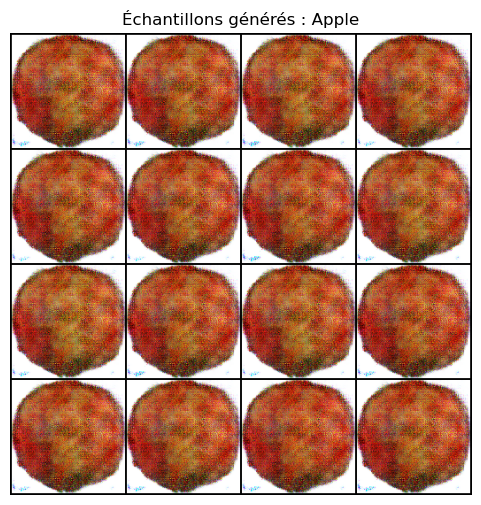

In [46]:
# Exemple d’utilisation — Générer 16 images de "Banana"

demo_label = "Apple"   # Remplace par n’importe quel nom de classe de ton dataset (ex : "Apple", "Orange", etc.)
save_path = generate_images_by_label(demo_label, num_images=16)

# Le chemin de la grille d’images générées sera affiché dans save_path

Génération de 16 images pour le label 'Papaya' (index=6)
Grille d’images générées sauvegardée dans : ./demo_outputs\Papaya_16.png


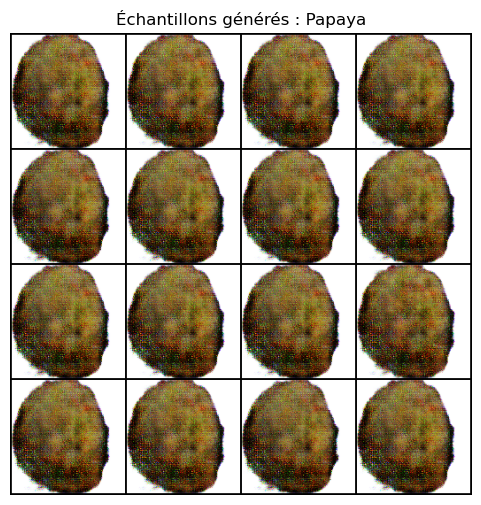

In [25]:
# Exemple d’utilisation — Générer 16 images de "Banana"

demo_label = "Papaya"   # Remplace par n’importe quel nom de classe de ton dataset (ex : "Apple", "Orange", etc.)
save_path = generate_images_by_label(demo_label, num_images=16)

# Le chemin de la grille d’images générées sera affiché dans save_path


In [48]:
import torch
import torchvision.utils as vutils

# ---- 1. 固定随机种子，保证噪声完全一样 ----
torch.manual_seed(0)

num_images = 16
label_name = "Grape"   # 换成你想看的类别

label_idx = class_to_idx[label_name]
noise = torch.randn(num_images, nz, device=device)
labels = torch.full((num_images,), label_idx, dtype=torch.long, device=device)

# ---- 2. 小函数：给定路径，加载一个 netG ----
def load_generator(path):
    netG = Generator(nz=nz, ngf=ngf, nc=nc,
                     num_classes=num_classes, image_size=image_size).to(device)
    state_dict = torch.load(path, map_location=device)
    netG.load_state_dict(state_dict)
    netG.eval()
    return netG

path_100 = "./checkpoints_dcgan_128_cond/generator_dcgan_128_cond.pth"
path_200 = "./checkpoints_dcgan_128_cond101-200/generator_dcgan_128_cond101-200.pth"

netG_100 = load_generator(path_100)
netG_200 = load_generator(path_200)

# ---- 3. 同一份噪声 + 标签，分别丢给两个模型 ----
with torch.no_grad():
    fake_100 = netG_100(noise, labels)
    fake_200 = netG_200(noise, labels)

    fake_100 = (fake_100 + 1) / 2   # [-1,1] -> [0,1]
    fake_200 = (fake_200 + 1) / 2

# ---- 4. 保存成两张不同命名的图，方便对比 ----
vutils.save_image(fake_100, f"./demo_outputs/{label_name}_epoch100.png", nrow=4)
vutils.save_image(fake_200, f"./demo_outputs/{label_name}_epoch200.png", nrow=4)

print("saved:", f"./demo_outputs/{label_name}_epoch100.png")
print("saved:", f"./demo_outputs/{label_name}_epoch200.png")

# 可选：再看看两组图片差多少（像素级对比）
diff = (fake_100 - fake_200).abs().max().item()
print("max |img_100 - img_200| =", diff)


C:\Users\sugarfree\AppData\Local\Temp\ipykernel_30512\2824340584.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(path, map_location=device)


saved: ./demo_outputs/Grape_epoch100.png
saved: ./demo_outputs/Grape_epoch200.png
max |img_100 - img_200| = 0.7455655336380005
